# 美国职业棒球赛数据探索

email:waynewqh@foxmail.com

### 数据背景说明

本次项目分析的数据集来自网站[seanlahman](http://www.seanlahman.com/baseball-archive/statistics/)的[2016 – comma-delimited version](http://seanlahman.com/files/database/baseballdatabank-2017.1.zip)。其中包含了从1871年到2016年美国职业棒球赛完整的棒球赛击球和投球数据，还包括防守数据、排名、球队数据、管理记录、季后赛数据等等，文档皆为CSV格式，数据说明[如文档](http://seanlahman.com/files/database/readme2016.txt)。

由于本人对真实棒球赛接触较少、知识有限，特别是美职棒和东亚差别也很大，因此希望能通过做这个项目从中学习更多棒球知识。

野手和捕手因为位置关系职能较复杂，比较难做对位分析，因此不考虑作为本次探索分析的数据。

本次数据探索着重于薪酬数据(Salaries.csv)、击打数据(Batting.csv)和投球数据(Pitching.csv)、球队数据(Teams.csv)，并且增加出场数据(Apperearances.csv)作为数据清洗时的参考对比。由于数据集包含了100多年的数据，数据量比较大，而且分析远古数据的意义也没有近期数据大，因此本次分析主要针对最近5年即2012-2016年。

在开始探索数据之前，首先提出几个希望能通过分析数据可以回答的问题：

* 球员的薪酬与表现有什么关系？
* 高薪酬的打者和投手相比其他球员表现是否更突出？
* 付出更多薪酬的球队是否能收获好成绩？

## 数据处理

### 首先导入内置函数和数据集

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import cm   

%matplotlib inline

In [2]:
#这是我比较感兴趣的5个数据集，在这里导入薪酬、出场、击打、投球和球队数据
salaries_raw = pd.read_csv('baseballdatabank-2017.1/core/Salaries.csv')
appearances_raw = pd.read_csv('baseballdatabank-2017.1/core/Appearances.csv')
batting_raw = pd.read_csv('baseballdatabank-2017.1/core/Batting.csv')
pitching_raw = pd.read_csv('baseballdatabank-2017.1/core/Pitching.csv')
teams_raw = pd.read_csv('baseballdatabank-2017.1/core/Teams.csv')

### 对导入的数据进行清洗

接下来提取2012-2016年的数据，然后查看是否有数值缺失，yearID代表每行数据的年份。

In [3]:
salaries_last_5_years = salaries_raw[salaries_raw['yearID'] >= 2012]
appearances_last_5_years = appearances_raw[appearances_raw['yearID'] >= 2012]
batting_last_5_years = batting_raw[batting_raw['yearID'] >= 2012]
pitching_last_5_years = pitching_raw[pitching_raw['yearID'] >= 2012]
teams_last_5_years = teams_raw[teams_raw['yearID'] >= 2012]

In [4]:
#查找缺失值，发现投球数据里一共出现了9个NaN缺失值
print 'salaries_last_5_years: {} missing data.'.format(salaries_last_5_years.isnull().sum().sum())
print 'appearances_last_5_years: {} missing data.'.format(appearances_last_5_years.isnull().sum().sum())
print 'batting_last_5_years: {} missing data.'.format(batting_last_5_years.isnull().sum().sum())
print 'pitching_last_5_years: {} missing data.'.format(pitching_last_5_years.isnull().sum().sum())
print 'teams_last_5_years: {} missing data.'.format(teams_last_5_years.isnull().sum().sum())

salaries_last_5_years: 0 missing data.
appearances_last_5_years: 0 missing data.
batting_last_5_years: 0 missing data.
pitching_last_5_years: 9 missing data.
teams_last_5_years: 0 missing data.


In [5]:
'''
查看有缺失值的列是哪些
通过观察发现9个NaN数据有3个出现在BAOpp上有6个出现在ERA上
BAOpp是对手的打击率,即对手打者的安打数除以打击数(H/AB)，而ERA则是9*ER/(IPouts/3)
显然如果分母为0，即对手击打数AB为0或者1局都没完成(IPouts = 0)，都是不能计算的。
'''
pitching_last_5_years.isnull().sum()[pitching_last_5_years.isnull().sum() != 0]

BAOpp    3
ERA      6
dtype: int64

In [6]:
#查带看NaN的行
pitching_last_5_years[pitching_last_5_years['BAOpp'].isnull()].iloc[:,10:]

,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
42512,0,0,0,0,0,0,2,0,NaN,NaN,0.0,0.0,0.0,0,2.0,0.0,0,0.0,0.0,0.0
42531,0,0,0,0,0,0,1,0,NaN,NaN,0.0,0.0,0.0,0,1.0,1.0,0,0.0,0.0,0.0
42770,0,0,2,0,0,0,1,0,NaN,0.0,0.0,2.0,0.0,0,2.0,0.0,0,0.0,1.0,0.0


In [7]:
pitching_last_5_years[pitching_last_5_years['ERA'].isnull()].iloc[:,10:]

,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
41562,0,0,0,1,2,1,1,0,1.0,NaN,0.0,0.0,0.0,0,2.0,1.0,2,0.0,0.0,0.0
42512,0,0,0,0,0,0,2,0,NaN,NaN,0.0,0.0,0.0,0,2.0,0.0,0,0.0,0.0,0.0
42531,0,0,0,0,0,0,1,0,NaN,NaN,0.0,0.0,0.0,0,1.0,1.0,0,0.0,0.0,0.0
42886,0,0,0,1,1,0,3,0,1.0,NaN,0.0,1.0,0.0,0,4.0,0.0,1,0.0,0.0,0.0
42923,0,0,0,2,4,0,3,0,1.0,NaN,0.0,0.0,0.0,0,5.0,0.0,4,0.0,0.0,0.0
43615,0,0,0,2,2,1,0,0,1.0,NaN,0.0,0.0,0.0,0,2.0,1.0,2,0.0,0.0,0.0


通过查看个案发现有2行数据是有2个缺失值，也就是说带缺失值的数据只有7行

观察发现ERA缺失的都未能完成一个完整局（IPouts = 0，棒球规则规定要出局三个打者才算完成1个IP）。

而BAOpp缺失的都是保送局（保送次数BB和投手面对击球手人数BFP相等，且大于0）。

由于登场打击数AB并不统计牺牲打(SH: Sacrifice Hits by opposing batters)，触身球(HBP: Hit By Pitch)和野手犯规，虽然原始数据没有统计AB，但由常识可推测都是0。由于这几位投手可能都是垃圾时间上场或者救火队员很快就被换下，可能没有太多统计意义，为了保持数据的完整性以方便统计，可以删掉这几条。

In [8]:
#删掉7条包含NaN的行
pitching_last_5_years = pitching_last_5_years.dropna()
print 'pitching_last_5_years have {} missing data.'.format(pitching_last_5_years.isnull().sum().sum())

pitching_last_5_years have 0 missing data.


In [9]:
'''
处理完pitching数据的缺失后，下面我关心的是appearance与batting和pitching之间的数据有没有冲突，
其实主要是对比出场次数G_all、G_p和G之间是否产生了统计错误
首先在各建立一个检验集，需要包含yearID，teamID和playerID这三个唯一特征，然后各自去检验G_all和G、G_p和G是否相等
'''
appearances_check = appearances_last_5_years[['yearID','teamID','playerID','G_all','G_p']].copy()
batting_check = batting_last_5_years[['yearID','teamID','playerID','G']].copy()
pitching_check = pitching_last_5_years[['yearID','teamID','playerID','G']].copy()

In [10]:
#首先检查batting和appearances聚合后的差异
check_diff1 = batting_check.merge(appearances_check, on=['yearID','teamID','playerID'], how = 'inner')
check_diff1[check_diff1['G_all'] != check_diff1['G']]

,yearID,teamID,playerID,G,G_all,G_p
1032,2012,SEA,pryorst01,27,26,26
1060,2012,ARI,ransoco01,17,26,0
1061,2012,ARI,ransoco01,9,26,0
1366,2012,CLE,wheelda01,13,12,12
2270,2013,BOS,millean01,38,37,37
3263,2014,OAK,fuldsa01,7,60,0
3264,2014,OAK,fuldsa01,53,60,0
3550,2014,LAA,leblawa01,1,10,10
3551,2014,LAA,leblawa01,9,10,10
3993,2014,TOR,santose01,26,27,26


playerID出现两次的可能是因为转会所导致（转会去另一家俱乐部没打上比赛，再转回来原俱乐部，比如最后两列，martimi02同一赛季在球队CLE先后出场了32和27次，而在apperrances里一并统计了合共59次出场）。

因为同样ID下的G相加都等于G_all，这个符合常识，但单个出现的playerID场数不相等。

观察发现这几位球员都是投手，少有击打数据，因此我推测可能在击打统计上出现了错误。

这里以appearance的G_p为准来修正batting里的G，santonse01那行是G_all出现错误，我们分析时只用batting的数据，因此需要修改的只有batting的3行，数量不多可以逐个修正。

In [11]:
#查看需要修改的三行数据的index
print batting_last_5_years[batting_last_5_years['playerID'] == 'pryorst01'][batting_last_5_years['yearID'] == 2012].index
print batting_last_5_years[batting_last_5_years['playerID'] == 'wheelda01'][batting_last_5_years['yearID'] == 2012].index
print batting_last_5_years[batting_last_5_years['playerID'] == 'millean01'][batting_last_5_years['yearID'] == 2013].index

Int64Index([96627], dtype='int64')
Int64Index([96961], dtype='int64')
Int64Index([97865], dtype='int64')


e:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
e:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
e:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [12]:
#逐个修改错误值
batting_last_5_years['G'][96627] = 26
batting_last_5_years['G'][96961] = 12
batting_last_5_years['G'][97865] = 37

e:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
e:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2885: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
e:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
e:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4:

In [13]:
#接下来检查pitching和appearances聚合后的差异
check_diff2 = pitching_check.merge(appearances_check, on=['yearID','teamID','playerID'], how = 'inner')
check_diff2[check_diff2['G_p'] != check_diff2['G']]

,yearID,teamID,playerID,G,G_all,G_p
43,2012,TOR,beckch01,14,15,15
508,2012,TBA,peraljo01,76,77,77
739,2013,NYN,atchisc01,50,51,51
1437,2013,HOU,wrighwe01,54,55,55
1590,2014,CLE,crockky01,43,44,44
1817,2014,LAA,leblawa01,1,10,10
1818,2014,LAA,leblawa01,9,10,10
2116,2014,TEX,tollesh01,64,65,65
2457,2015,TBA,gomesbr01,63,64,64
2524,2015,KCA,hochelu01,49,50,50


In [14]:
#总共有12个数据需要修正，同样地，以G_p来逐个修正pitching里的G，这里取出index值统一加1即可
pl5y = pitching_last_5_years
#把带错误值的index索引值取出来作为一个list合并修改
edit_list = (list(pl5y[pl5y['playerID'] == 'beckch01'][pl5y['yearID'] == 2012][pl5y['teamID'] == 'TOR'].index)+\
list(pl5y[pl5y['playerID'] == 'peraljo01'][pl5y['yearID'] == 2012][pl5y['teamID'] == 'TBA'].index)+\
list(pl5y[pl5y['playerID'] == 'atchisc01'][pl5y['yearID'] == 2013][pl5y['teamID'] == 'NYN'].index)+\
list(pl5y[pl5y['playerID'] == 'wrighwe01'][pl5y['yearID'] == 2013][pl5y['teamID'] == 'HOU'].index)+\
list(pl5y[pl5y['playerID'] == 'crockky01'][pl5y['yearID'] == 2014][pl5y['teamID'] == 'CLE'].index)+\
list(pl5y[pl5y['playerID'] == 'tollesh01'][pl5y['yearID'] == 2014][pl5y['teamID'] == 'TEX'].index)+\
list(pl5y[pl5y['playerID'] == 'gomesbr01'][pl5y['yearID'] == 2015][pl5y['teamID'] == 'TBA'].index)+\
list(pl5y[pl5y['playerID'] == 'hochelu01'][pl5y['yearID'] == 2015][pl5y['teamID'] == 'KCA'].index)+\
list(pl5y[pl5y['playerID'] == 'gracema02'][pl5y['yearID'] == 2016][pl5y['teamID'] == 'WAS'].index)+\
list(pl5y[pl5y['playerID'] == 'janseke01'][pl5y['yearID'] == 2016][pl5y['teamID'] == 'LAN'].index)+\
list(pl5y[pl5y['playerID'] == 'jimenub01'][pl5y['yearID'] == 2016][pl5y['teamID'] == 'BAL'].index)+\
list(pl5y[pl5y['playerID'] == 'sampsad01'][pl5y['yearID'] == 2016][pl5y['teamID'] == 'SEA'].index))

e:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [15]:
pitching_last_5_years['G'][edit_list] = pitching_last_5_years['G'][edit_list] + 1

###  预处理需要分析的数据

由于提出的问题都是与球员有关，而且球员可能会在年中转会的，也就是在同一个年份里，某些playerID不唯一。

因此最好把数据各自以playerID来分组。

In [16]:
#查看各数据框架长度
print 'salaries_last_5_years：{}'.format(len(salaries_last_5_years.groupby('playerID')))
print 'appearances_last_5_years：{}'.format(len(appearances_last_5_years.groupby('playerID')))
print 'batting_last_5_years：{}'.format(len(batting_last_5_years.groupby('playerID')))
print 'pitching_last_5_years：{}'.format(len(pitching_last_5_years.groupby('playerID')))

salaries_last_5_years：1559
appearances_last_5_years：2366
batting_last_5_years：2366
pitching_last_5_years：1359


可以看出其他数据框架的长度小于或等于appearances，这个符合常识。

在之前利用了appearances来检验数据，后面的分析里appearances的数据对我们没什么多大意义了。

salary的数据长度比较短，可能部分球员的薪酬并没有公开，因此在处理分析薪酬与表现的关系时只能作为样本来看待。

下面来新建以playerID来分组的dataframe，年份yearID的sum没意义，而球会注册顺序stint的sum对球员表现数据不重要，可以删掉。

但由于球员在美职棒登陆年数并不相同，如果要归一化所有指标的话最好能除以年数得出均值来比较，因此可以增加一个column 'years'来表示这5年里球员在职业赛场登陆年数。

In [17]:
'''
打击数据在分组了之后要删除掉从未上过打席的球员（即AB=0）
这部分人大多是投手和捕手，对我们统计击打数据没有意义
另外由于数据集里收集的大多是累计型指标，这里可以增加几个统计型的击球手表现指标
比如击打率AVG、上垒率OBP、长打率SLG以及攻击指数OPS这四个常见的表现指标，作为分析时的参考
公式如下：
AVG = H / AB
OBP = (H + BB) / (AB + BB +SH)
SLG = (H + 2B + 3B * 2 + HR * 3) / AB
OPS = OBP + SLG
'''
batting_unique_playerID = batting_last_5_years.groupby('playerID').sum().drop(['yearID','stint'],axis=1).reset_index()
batting_unique_playerID = batting_unique_playerID[batting_unique_playerID['AB'] != 0]

batting_unique_playerID['AVG'] = batting_unique_playerID['H'] / batting_unique_playerID['AB']
batting_unique_playerID['OBP'] = (batting_unique_playerID['H'] + batting_unique_playerID['BB'])\
                                / (batting_unique_playerID['AB'] + batting_unique_playerID['BB'] + batting_unique_playerID['SH'])
batting_unique_playerID['SLG'] = (batting_unique_playerID['H'] + batting_unique_playerID['2B'] + batting_unique_playerID['3B'] * 2\
                                + batting_unique_playerID['HR'] * 3) / batting_unique_playerID['AB']
batting_unique_playerID['OPS'] = batting_unique_playerID['OBP'] + batting_unique_playerID['SLG']

In [18]:
'''
在pitching数据里，由于BAOpp = H/AB和ERA = ER*9/(IPouts/3)都是统计型比率数据而非累计型数据，因此无法直接相加
这里先要推算出AB这个列，等分组后再重新计算一次
由于H数为0的时候，BAOpp也为0，为了后面计算方便AB的缺失值可以填1
'''
pitching_last_5_years['AB'] = (pitching_last_5_years['H'] / pitching_last_5_years['BAOpp']).fillna(1)

In [19]:
'''同理也可以加上对手上垒率OBP和登场胜率WR这两个投手的表现指标'''
pitching_unique_playerID = pitching_last_5_years.groupby('playerID').sum().drop(['yearID','stint'],axis=1).reset_index()
pitching_unique_playerID['BAOpp'] = pitching_unique_playerID['H'] / pitching_unique_playerID['AB']
pitching_unique_playerID['ERA'] = pitching_unique_playerID['ER'] * 27 / pitching_unique_playerID['IPouts']

pitching_unique_playerID['OBP'] = (pitching_unique_playerID['H'] + pitching_unique_playerID['BB'])\
                                / (pitching_unique_playerID['AB'] + pitching_unique_playerID['BB'] + pitching_unique_playerID['SH'])
pitching_unique_playerID['WR'] = pitching_unique_playerID['W']  / pitching_unique_playerID['G']

In [20]:
'''
由于球员可能会在年中转会，因此每个playID下的yearID可能会有5个以上
这里希望能计算出球员登陆职棒的年数，如果只用一个df来处理会有难度
因此这里我把salaries_last_5_years按yearID拆分成5个，先按年份来分组
'''
salaries_2012 = salaries_last_5_years[salaries_last_5_years['yearID'] == 2012]
salaries_2013 = salaries_last_5_years[salaries_last_5_years['yearID'] == 2013]
salaries_2014 = salaries_last_5_years[salaries_last_5_years['yearID'] == 2014]
salaries_2015 = salaries_last_5_years[salaries_last_5_years['yearID'] == 2015]
salaries_2016 = salaries_last_5_years[salaries_last_5_years['yearID'] == 2016]

In [21]:
#依此分组求和，增加一个数据列'years'来表示球员的登陆年数，最后合并求和能得出总薪酬和登陆年数
salaries_2012_unique = salaries_2012.groupby('playerID').sum().drop('yearID',axis = 1).reset_index()
salaries_2012_unique['years'] = 1

salaries_2013_unique = salaries_2013.groupby('playerID').sum().drop('yearID',axis = 1).reset_index()
salaries_2013_unique['years'] = 1

salaries_2014_unique = salaries_2014.groupby('playerID').sum().drop('yearID',axis = 1).reset_index()
salaries_2014_unique['years'] = 1

salaries_2015_unique = salaries_2015.groupby('playerID').sum().drop('yearID',axis = 1).reset_index()
salaries_2015_unique['years'] = 1

salaries_2016_unique = salaries_2016.groupby('playerID').sum().drop('yearID',axis = 1).reset_index()
salaries_2016_unique['years'] = 1

salaries_unique_playerID = pd.concat([salaries_2012_unique , salaries_2013_unique , salaries_2014_unique ,\
                                      salaries_2015_unique , salaries_2016_unique]).groupby('playerID').sum().reset_index()

接下来处理teams的数据

这里因为选用的是常规赛数据，并没有添加季后赛，因此我们也不关心球队是否拿到分区冠军晋级季后赛。赛季的数据基本可以综合体现球队表现。

由于需要合并球队5年数据，但ERA、守备率FP、主场击打优势BPF、主场投球优势PPF并不能简单地去求sum，需要做处理。

ERA可以使用公式ERA = 27 * ER/IPouts在数据分组后来重新求值。

FP虽然有公式FP = (FC-E)/FC，但数据里并没有给出守备机会FC(fielding chances)，不过由于这个数是一个近似1的值（因为失误数E很小），因此可以利用求mean来近似真实值。

另外两个指标BPF、PPF也可以用mean来归一化。

In [22]:
#通过teamID来分组求和
teams_unique_teamID = teams_last_5_years.groupby('teamID').sum().reset_index().drop('yearID',axis = 1)

In [23]:
#处理统计型数据
teams_unique_teamID['FP'] = teams_unique_teamID['FP'] / 5
teams_unique_teamID['BPF'] = teams_unique_teamID['BPF'] / 5
teams_unique_teamID['PPF'] = teams_unique_teamID['PPF'] / 5
teams_unique_teamID['ERA'] = teams_unique_teamID['ER'] * 27 / teams_unique_teamID['IPouts']

In [24]:
'''
接下来再添加球队的salary，虽然原始数据里没有得到总体salary数据，
在这里只能假设样本的salary能够体现球队的总体情况
但如果样本分布不均匀，我们的分析可能会有很大误差
'''
salaries_teams = salaries_last_5_years.groupby('teamID').sum().reset_index().drop('yearID',axis = 1)

In [25]:
#聚合薪酬到球队数据里
teams_unique_teamID = teams_unique_teamID.merge(salaries_teams, on = 'teamID', how= 'inner')

数据经过清洗后都没有缺失值和错误值，而且通过对唯一的playerID和teamID作分组得到了后面想要分析要用的数据。

后续分析会根据对数据的探索深入程度，再进行聚合、归一化等处理。

## 数据探索

### 相关性分析与可视化

首先来分析第一个问题：球员薪酬与表现有什么关系?

最简单的方法就是建立薪酬与其他指标的相关性，直观上通过可视化观察得出初步结论。

#### 首先来了解一下球员薪酬分布

In [26]:
#为了比较球员的薪酬，需要把总薪酬转换成年薪
salaries_unique_playerID['salary'] = salaries_unique_playerID['salary'] / salaries_unique_playerID['years']

In [27]:
salaries_unique_playerID['salary'].describe()

count    1.559000e+03
mean     2.883753e+06
std      4.266547e+06
min      4.800000e+05
25%      5.115000e+05
50%      8.750000e+05
75%      3.166833e+06
max      2.550000e+07
Name: salary, dtype: float64

可以看出平均薪酬是2,883,753，但中位数只有875,000不到平均值的三分之一，可以预计薪酬的分布应该不太均匀

这里分别用直方图、箱线图和饼状图来表示球员的薪酬分布

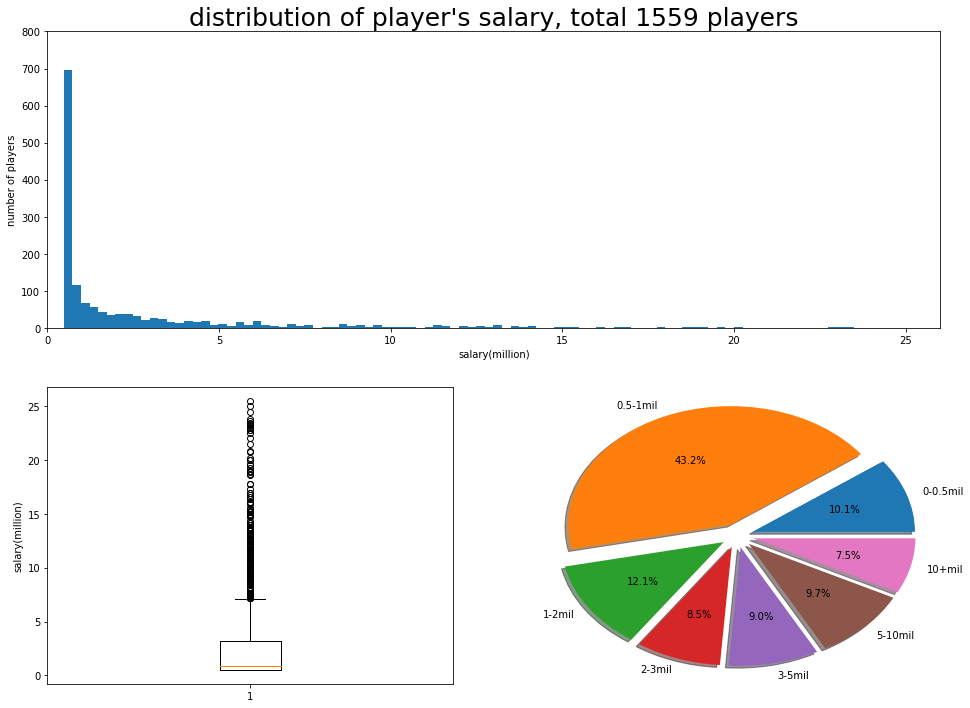

In [28]:
#在一个图示里分三个子图画出直方图、箱线图和饼状图
def draw_salary():
    #直方图和箱线图的图示数据，这里薪酬单位取million
    draw_var = salaries_unique_playerID['salary'] / 1000000
    #饼状图的各块的分组数据
    draw_var_pie = []
    draw_var_pie.append(len(draw_var[draw_var <= 0.5]))
    draw_var_pie.append(len(draw_var[draw_var <= 1]) - len(draw_var[draw_var <= 0.5]))
    draw_var_pie.append(len(draw_var[draw_var <= 2]) - len(draw_var[draw_var <= 1]))
    draw_var_pie.append(len(draw_var[draw_var <= 3]) - len(draw_var[draw_var <= 2]))
    draw_var_pie.append(len(draw_var[draw_var <= 5]) - len(draw_var[draw_var <= 3]))
    draw_var_pie.append(len(draw_var[draw_var <= 10])- len(draw_var[draw_var <= 5]))
    draw_var_pie.append(len(draw_var) - len(draw_var[draw_var <= 10])) 
    #初始化图形和各子图对象
    fig = plt.figure(figsize = (16,12))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)
    #设置直方图
    ax1.hist(draw_var,bins = 100)
    ax1.axis([0,26,0,800])
    ax1.set_title('distribution of player\'s salary, total {} players'.format(len(draw_var)), fontsize = 25)
    ax1.set_ylabel('number of players')
    ax1.set_xlabel('salary(million)')
    #设置箱线图
    ax2.boxplot(draw_var)
    ax2.set_ylabel('salary(million)')
    #设置饼状图
    ax3.pie(draw_var_pie,
            explode = [0.1,0.1,0.1,0.1,0.1,0.1,0.1],
            labels = ['0-0.5mil', '0.5-1mil', '1-2mil', '2-3mil', '3-5mil', '5-10mil', '10+mil'],
            labeldistance = 1.1,
            shadow = True,
            autopct = '%1.1f%%')
    plt.show()  
    
draw_salary()

可以看到直方图呈现L型分布，箱线图上异常点很多。

图示说明大部分球员的年薪都差不多在中位数附近，超过一半人的平均年薪不足一百万。

高薪球员分布相对比较均匀，而拿千万年薪的亦不乏少数，球员薪酬的两极化明显。

#### 先来研究一下球员击打指标和薪酬的关系

In [29]:
#合并薪酬和击打数据
batting_salary = salaries_unique_playerID.merge(batting_unique_playerID, on = 'playerID', how = 'inner')

In [30]:
#查看一下每个column的序号，以免弄错
for num in range(len(batting_salary.columns)):
    print str(num) + ':' + batting_salary.columns[num] + ',',

0:playerID, 1:salary, 2:years, 3:G, 4:AB, 5:R, 6:H, 7:2B, 8:3B, 9:HR, 10:RBI, 11:SB, 12:CS, 13:BB, 14:SO, 15:IBB, 16:HBP, 17:SH, 18:SF, 19:GIDP, 20:AVG, 21:OBP, 22:SLG, 23:OPS,


In [31]:
'''
在接下来的分析里，为了在和平均年薪比较时有统一标准
这里把累计型指标都除以年数years做归一化
'''
def batting_divide():
    i = 3
    while i <= 19:
        batting_salary.iloc[:,i] = batting_salary.iloc[:,i] / batting_salary.iloc[:,2]
        i = i + 1

batting_divide()

In [32]:
'''
为了更好突出击球手的击打表现，我认为可以排除不怎么上场击球的专职守备球员
我认为可以截取出平均击打登场数AB的四分位数Q1以上的球员来做比较
'''
batting_AB_Q1 = batting_salary[batting_salary['AB']  >= batting_salary['AB'].quantile(0.25)].drop('playerID',axis = 1)

In [33]:
print len(batting_salary)
print len(batting_AB_Q1)

1272
955


样本行数没有小很多，可以接受

In [34]:
#建立batting指标间的相关性矩阵
batting_correlations_matrix = batting_AB_Q1.corr()

In [35]:
'''
相关性矩阵由于项目太多，观察起来不直观
因此可以把矩阵转换成热图来表示
'''
def draw_heatmap(df_matrix):  
    #imshow函数对numpy.float64格式报错，所以需要转换成float
    def turnfloat(x):
        return np.float64(x).item()
    #draw_var为需要示图数据
    draw_var = df_matrix.applymap(turnfloat)
    #labels为x,y轴标签
    labels = list(df_matrix.columns)
    #初始化色图和图形对象
    cmap = cm.get_cmap('Reds',1000)
    fig, ax = plt.subplots(figsize = (16,12)) 
    #设置子图属性
    ax.set_yticks(np.arange(0, len(labels)))  
    ax.set_yticklabels(labels)  
    ax.set_xticks(np.arange(0, len(labels)))  
    ax.set_xticklabels(labels, rotation = 45)
    ax.set_title('the heatmap of correlation coefficients matrix', fontsize = 25)
    #利用imshow建立矩阵置换成热图对象，图像转换用邻近插值法，纵横比为自动，由于相关性是-1到1，所以色条最小值和最大值取-1和1
    map = ax.imshow(draw_var, interpolation = 'nearest', cmap = cmap, aspect = 'auto', vmin = -1, vmax = 1) 
    #设置色条的属性
    cb = plt.colorbar(mappable = map, cax = None, ax = None, shrink = 0.5)  
    plt.show()

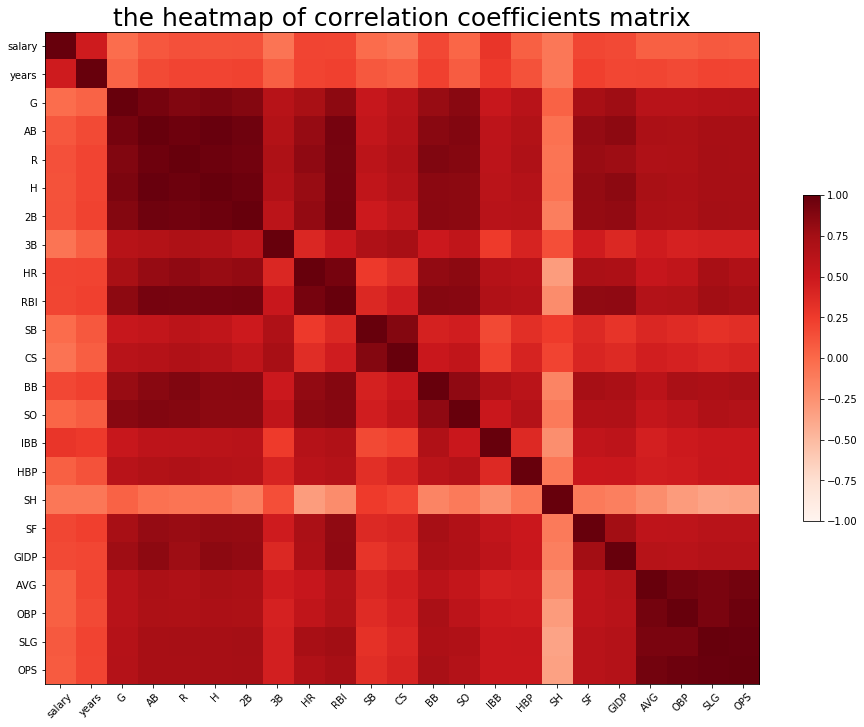

In [36]:
draw_heatmap(batting_correlations_matrix)

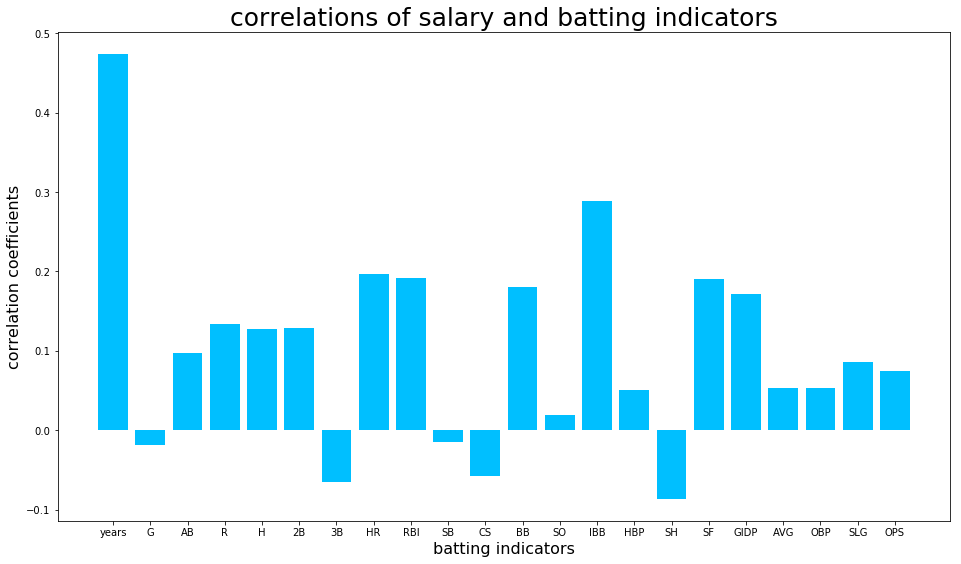

In [37]:
#画出和薪酬salary与其他击打指标的相关性直方图
def draw_batting_bar():
    draw_var = batting_correlations_matrix['salary'].drop(['salary'])
    #初始化图形对象
    fig,ax = plt.subplots(figsize = (16,9)) 
    #设置子图属性
    ax.set_xlabel('batting indicators', fontsize = 16)
    ax.set_ylabel('correlation coefficients', fontsize = 16)
    ax.set_title('correlations of salary and batting indicators', fontsize = 25)
    #在子图ax中建立bar对象
    ax.bar(np.arange(len(draw_var)), draw_var, width = 0.8, color = 'deepskyblue')
    #利用setp设置ax对象的属性，修改x轴标签
    plt.setp(ax, xticks = np.arange(len(draw_var)), xticklabels = list(draw_var.index))
    plt.show()
    
draw_batting_bar()

观察发现球员的平均薪酬居然和球员登陆职业联赛的年数相关性最大，此外累计型的指标中相关性最高的是被故意保送次数IBB，全垒打数HR、回垒得分数RBI、高飞牺牲打数SF、保送次数BB和被双杀次数GIDP紧随其后。

薪酬和最能表现击球手综合击打实力的统计性指标打击率AVG、上垒率OBP、长打率SLG和攻击指数OPS的正相关性并不大。

牺牲打数SH负相关性最高，三垒打数3B、盗垒失败数CS也有一定负相关性

登场场数G、盗垒次数SB和三振出局数SO和薪酬基本没什么相关性。

根据棒球常识，我认为除了years外其他高正相关性的指标都和球员强打的实力有关，强打者一般需要垒上有跑者才能发挥威力，这类球员很少牺牲自己去为队友抢垒，不过有能力经常击出全垒打从而让跑者回垒得分，但也很容易会被投手保送上垒而得不到挥棒机会。

因此初步推测薪酬和击球手的经验关系最大，而且和击球强打能力也有很大关系，但和综合击打实力可能关系不大。

#### 接下来研究投手数据和薪酬的关系

In [38]:
#把salary聚合到pitching里
pitching_salary = salaries_unique_playerID.merge(pitching_unique_playerID, on = 'playerID', how = 'inner')

In [39]:
#查看一下每个column的序号，以免弄错
for num in range(len(pitching_salary.columns)):
    print str(num) + ':' + pitching_salary.columns[num] + ',',

0:playerID, 1:salary, 2:years, 3:W, 4:L, 5:G, 6:GS, 7:CG, 8:SHO, 9:SV, 10:IPouts, 11:H, 12:ER, 13:HR, 14:BB, 15:SO, 16:BAOpp, 17:ERA, 18:IBB, 19:WP, 20:HBP, 21:BK, 22:BFP, 23:GF, 24:R, 25:SH, 26:SF, 27:GIDP, 28:AB, 29:OBP, 30:WR,


In [40]:
#同样地，把累计型数据归一化
def pithching_divide():
    i = 3
    while i <= 15:
        pitching_salary.iloc[:,i] = pitching_salary.iloc[:,i] / pitching_salary.iloc[:,2]
        i = i + 1
    i = 18
    while i <= 28:
        pitching_salary.iloc[:,i] = pitching_salary.iloc[:,i] / pitching_salary.iloc[:,2]
        i = i + 1
        
pithching_divide()

In [41]:
'''
由于投手是个特殊角色，但有时也会有并非专职的救火队员上场
因此在分析时排除掉一年上场也不足一次的球员
才能更好体现投手的表现
'''
pitching_salary_new = pitching_salary[pitching_salary['G'] >= 1].drop('playerID',axis = 1)

In [42]:
print len(pitching_salary)
print len(pitching_salary_new)

855
808


数据行数没有减少很多，可以接受

In [43]:
#投手指标的相关性矩阵
pitching_correlations_matrix = pitching_salary_new.corr()

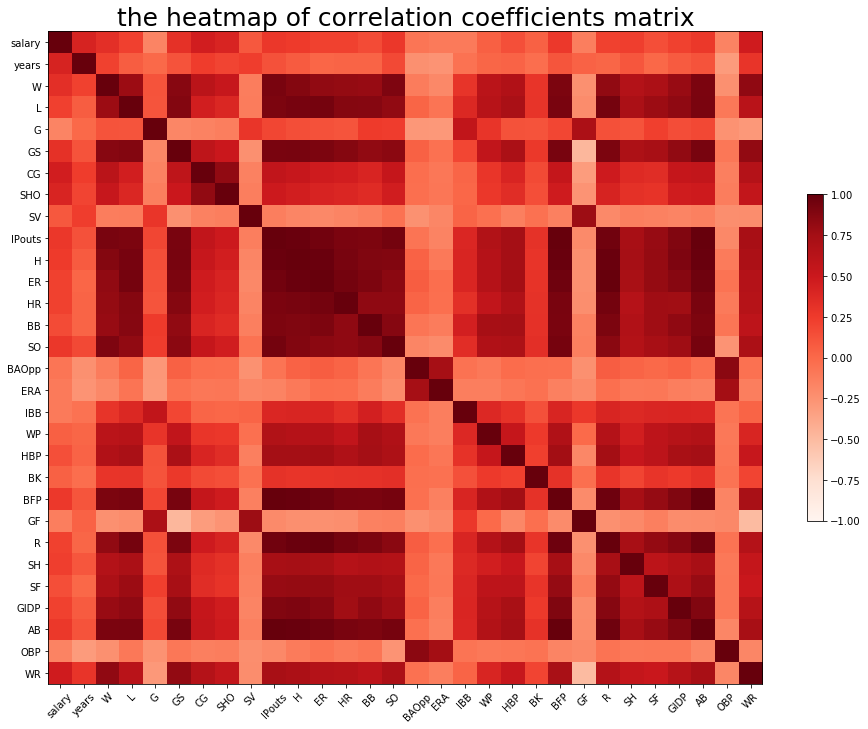

In [44]:
#投手指标的相关性热图
draw_heatmap(pitching_correlations_matrix)

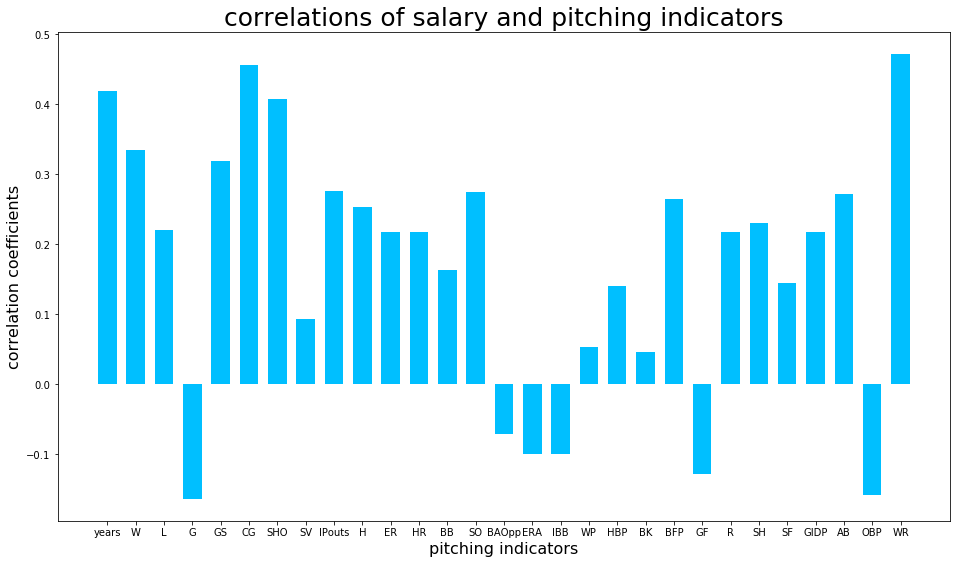

In [45]:
#画出薪酬与其他投手指标的相关性直方图
def draw_pitching_bar():
    draw_var = pitching_correlations_matrix['salary'].drop(['salary'])
    fig, ax = plt.subplots(figsize = (16,9))
    #设置子图属性
    ax.set_xlabel('pitching indicators', fontsize = 16)
    ax.set_ylabel('correlation coefficients', fontsize = 16)
    ax.set_title('correlations of salary and pitching indicators', fontsize = 25)
    #建立bar对象
    ax.bar(np.arange(len(draw_var)), draw_var, width = 0.65, color = 'deepskyblue') 
    plt.setp(ax, xticks = np.arange(len(draw_var)), xticklabels = list(draw_var.index))
    plt.show()
    
draw_pitching_bar()

可以看出和薪酬正相关性最高的前四项是年份数years、完投场数CG、完封场数SHO和在场胜率WR。

负相关性的有上场场数G、对手打击率BAOpp、对手得分率ERA、保送上垒数IBB、终局战上场GF和对手上垒数OBP。

如果高薪酬的球员都有好实力能带来更高的在场胜率，那么体现对手表现的指标BAOpp、ERA、IBB和OBP当然是越低越好。

不过也可以推测高薪酬球员同时也是首发GS较多的投手，因为完投的就是要首发打完九局，完封则是零封对手的完投，都是和薪酬高正相关的一类上场指标。

替补投手相关的指标救援点数SV和终局战上场GF时负相关关系，也证明了高薪酬投手很大可能不会当替补。

因为首发投手投的局数偏多，需要在不同场次轮换，所以登场场数G会比经常要上场替补的投手要少也就不奇怪了。

因此可以初步推论高薪酬投手基本都是球队里的首发投手，他们能够更稳定地封杀对手的得分能力，从而为球队获得更高的胜率。

### 高薪酬球员和一般球员的比较

为了回答第二个问题，这里想比较高薪酬球员的与平均值的表现。

需要拿出前50名最高平均薪酬的球员出来和总体进行比较，看看哪些指标具备显著性

由于指标数据大小不一，所以要对所有数据指标进行归一化处理，这里可以各自除以各自列的最大值，这样可以放在同一个图上比较。

In [46]:
#取出最高薪的前50位球员数据
batting_salary_top50 = batting_AB_Q1.sort_values('salary',ascending = False)[0:50]

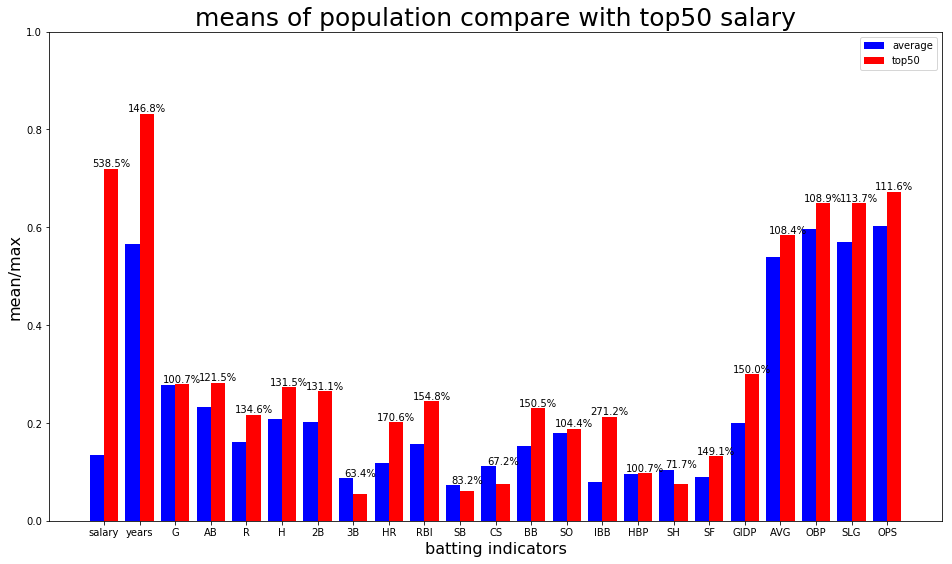

In [47]:
#画出两组数据的条形图
def draw_batting_compare():
    #对需要图示的数据作归一化处理
    draw_var1 = batting_AB_Q1.mean() / batting_AB_Q1.max()
    draw_var2 = batting_salary_top50.mean() / batting_AB_Q1.max()
    #建立一个长度为指标数量的排序，对应x轴的位置
    var_array = np.arange(len(draw_var1))
    #初始化图形对象
    fig, ax = plt.subplots(figsize = (16,9)) 
    #设置子图属性
    #设置y轴的标签，指标归一化后的数据值大小是[0,-1]
    ax.set_ylim([0,1])
    ax.set_xlabel('batting indicators', fontsize = 16)
    ax.set_ylabel('mean/max', fontsize = 16)
    ax.set_title('means of population compare with top50 salary', fontsize = 25)
    #建立两个bar对象
    ax.bar(var_array, draw_var1, width = 0.4, color = 'b', label = 'average')
    ax.bar(var_array + 0.4, draw_var2, width=0.4, color = 'r', label = 'top50')
    #设置x轴的标签属性
    plt.setp(ax, xticks = var_array + 0.2, xticklabels=list(batting_AB_Q1.columns))
    #设置每组bar上var2除以var1的值的比例文本
    #text的x轴位置，放在第二根bar上
    xpos = var_array + 0.4
    #y轴位置，放在较高的bar上
    ypos = list(draw_var2)    
    i = 0 
    while i < len(draw_var2):
        if draw_var1[i] > draw_var2[i]:
            ypos[i] = draw_var1[i]
        i = i + 1
    #按位置插入文本，用百分比表示
    for pos in var_array:
        ax.text(xpos[pos], ypos[pos], str(round(draw_var2[pos] / draw_var1[pos] * 100,1)) + '%', \
                 ha = 'center', va = 'bottom', rotation = 0)
    #显示条形图标签
    ax.legend()
    plt.show()
    
draw_batting_compare()

观察发现薪酬top50的击球手虽然登场次数(G、AB)都平均值比起来差不多，但经验(years)更丰富，而薪酬则是平均值的5倍以上。

但可以看出击打率AVG、上垒率OBP、长打率SLG和攻击指数OPS上，top50和平均水准相比显著性好像不太高。累积型指标3B、SB、CS、SH都比平均值要低，也证明了高薪击球手很少去做蓝领工作。

不过top50的全垒打数HR和回垒打点数RBI却是平均值的1.5倍以上，和登场打击次数只有1.2倍不到相比，有一定显著性。故意保送IBB是平均水平的2.5倍以上，显然对方投手面对这些高薪酬击球员时非常忌惮他们的击打能力，如果垒上没人或者只有一垒有人，那么保送战术是对防守方有利的。

这里也印证了刚才猜测高薪酬击球手大都是球队里的强打主炮的猜想。

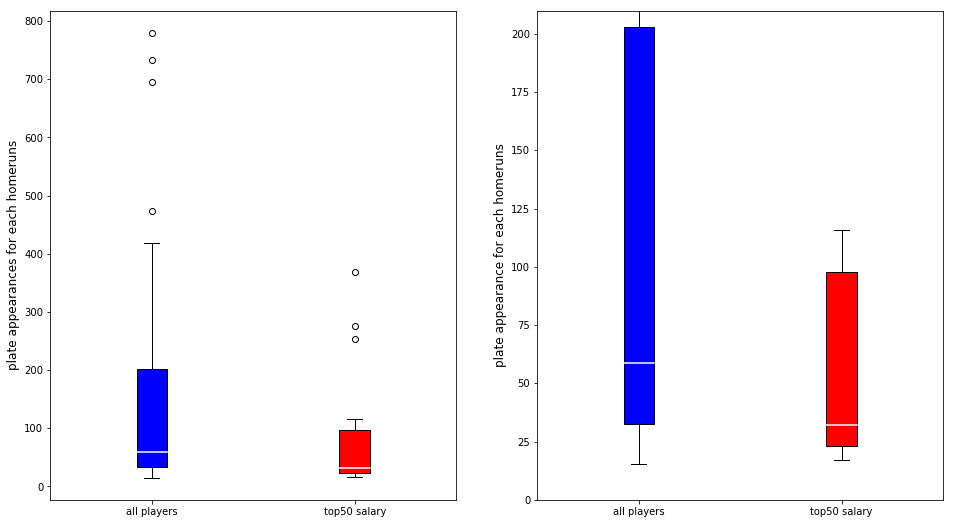

In [48]:
'''
虽然上面猜测高薪酬击球手是强打
但由于全垒打等累计型指标和AB是正相关的，因此出场更多的高薪酬球员获得更多的全垒打数也不奇怪
如果要比较高薪酬球员与平均水准的强打实力，一个是使用统计性指标，比如SLG
这里我新增一个可以体现球员全垒打能力的指标每打出一个全垒打所需要的上打席次数PA/HR（用全垒打率HR/PA不够直观）
其中上打席次数PA = AB + BB + HBP + SH
采用PA而不是AB作为分母是需要考虑到高薪酬球员显著的被保送次数以及牺牲打战术，PA更能真实体现球员的全部出场数
下面通过箱线图来比较高薪酬击球员和平均水平其分布如何。
'''
def draw_PA_pre_HR():
    draw_var1 = (batting_AB_Q1['AB'] + batting_AB_Q1['BB'] + batting_AB_Q1['HBP'] + batting_AB_Q1['SH']) / batting_AB_Q1['HR']
    draw_var2 = (batting_salary_top50['AB'] + batting_salary_top50['BB'] + batting_salary_top50['HBP'] + batting_salary_top50['SH']) \
                / batting_salary_top50['HR']

    fig = plt.figure(figsize = (16,9))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    #设置箱线图属性
    boxplt1 = ax1.boxplot([draw_var1, draw_var2], patch_artist=True)
    ax1.set_ylabel('plate appearances for each homeruns', fontsize = 12)
    plt.setp(ax1, xticklabels = ['all players', 'top50 salary'])
    #放大实体部分
    boxplt2 = ax2.boxplot([draw_var1, draw_var2], patch_artist=True)
    ax2.set_ylabel('plate appearance for each homeruns', fontsize = 12)
    ax2.set_ylim([0, 210])
    plt.setp(ax2, xticklabels = ['all players', 'top50 salary'])
    #统一修改每个子图的箱体和中位线的颜色
    boxplts = [boxplt1, boxplt2]
    for boxplt in boxplts:
        boxplt['boxes'][0].set_facecolor('b')
        boxplt['boxes'][1].set_facecolor('r')
        for medianline in boxplt['medians']:
            medianline.set(color = 'w', linewidth = 1.5)
    plt.show()
    
draw_PA_pre_HR()

可以看出高薪酬击球手每击出一个全垒打所需的上打席次数，Q1、Q2、Q3都明显少于总体水平，且箱体更小，分布更加集中。

高薪酬球员大部分人都可以在登场100次以内击出一个全垒打，中位数水平只需大概30次，而总体的中位数水平则需要60次。

因此相比之下高薪酬球员的全垒打能力明显更强，表现更稳定。

In [49]:
#接下来分析top50薪酬的投手和平均水平的比较
pitching_salary_top50 = pitching_salary_new.sort_values('salary',ascending = False)[0:50]

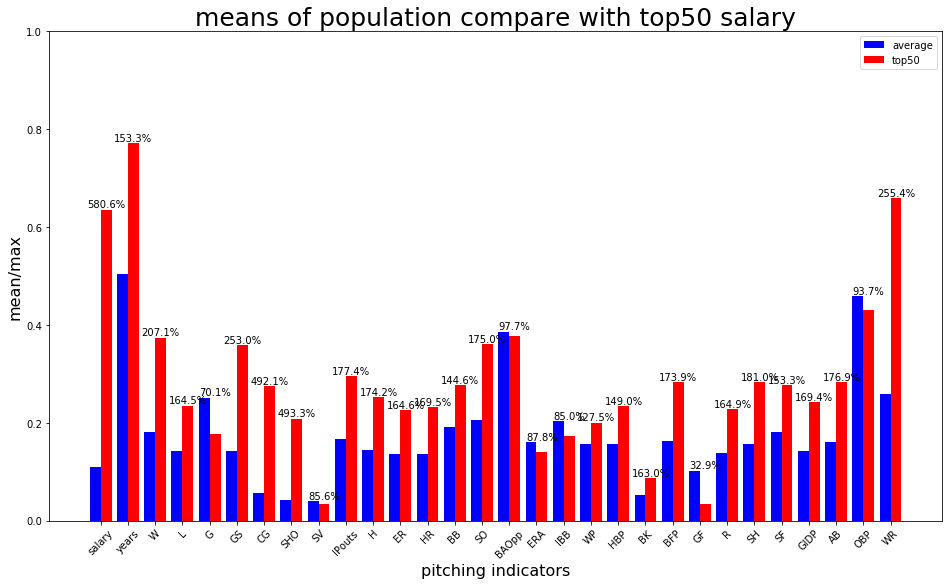

In [50]:
#画出两组数据的条形图
def draw_pitching_compare():
    #归一化处理
    draw_var1 = pitching_salary_new.mean() / pitching_salary_new.max()
    draw_var2 = pitching_salary_top50.mean() / pitching_salary_new.max()
    #建立一个长度为指标数量的排序
    var_array = np.arange(len(draw_var1))
    #初始化图形和子图对象
    fig, ax = plt.subplots(figsize = (16,9)) 
    #设置子图属性
    ax.set_ylim([0,1])
    ax.set_xlabel('pitching indicators',fontsize=16)
    ax.set_ylabel('mean/max',fontsize=16)
    ax.set_title('means of population compare with top50 salary',fontsize=25)
    #建立两个条形图对象
    ax.bar(var_array, draw_var1, width = 0.4, color = 'b', label = 'average')
    ax.bar(var_array + 0.4, draw_var2, width = 0.4, color = 'r', label = 'top50')
    #设置x轴的标签属性
    plt.setp(ax, xticks = var_array + 0.2, xticklabels = list(pitching_salary_new.columns))
    #由于x轴项目太多标签重合了，修改标签对象的倾斜值
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation = 45)
    #设置每组bar上var2除以var1的值的比例文本
    xpos = var_array + 0.4
    ypos = list(draw_var2)
    i = 0 
    while i < len(draw_var2):
        if draw_var1[i] > draw_var2[i]:
            ypos[i] = draw_var1[i]
        i = i + 1
    for pos in var_array:
        ax.text(xpos[pos], ypos[pos], str(round(draw_var2[pos] / draw_var1[pos] * 100,1)) + '%', \
                 ha = 'center', va = 'bottom')       
    ax.legend()
    plt.show()
    
draw_pitching_compare()

观察发现top50的薪酬是平均水平的5.7倍左右，完投比赛数CG和完封比赛SHO则是接近5倍。

虽然高薪酬投手的登场场数G只有平均水平的70%不到，但首发次数GS是2.5倍，完成局数是1.7倍，在此可以推测高薪酬投手确实是球队的主力投手，他们因为要打更多的局数所以需要轮休（实际上通过观察#pitching_salary_top50[['G','GS']].mean()可以发现高薪酬投手的平均出场数是30场，首发25场左右，相比球队一个赛季平均需要打160场以上比赛来说，基本是打1休4的节奏），而且胜率也比平均水平高很多。

H、ER、HR、BB和SO等累计指标考虑到和IPouts的高正相关性，高薪酬投手和平均水平的差别可能不大。

不过救援点数SV、对手打击率BAOpp、防御率ERA和对手上垒率OBP跟平均水平差不多，可能说明了高薪投手的个人表现或许不出色（要勉强投手9局全部投出高速球去追求三振也太难了），但确实有实力（比如封杀对方盗垒、和野手配合打出接杀战术）能够提高在场胜率，带领球队走向胜利。

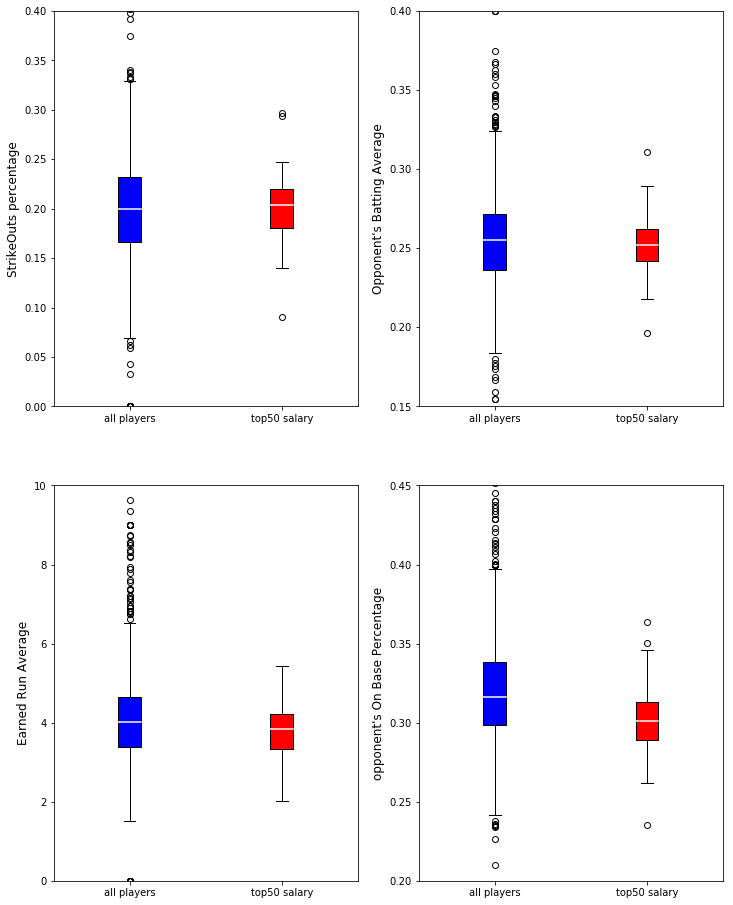

In [51]:
'''
由于上面分析得出高薪投手的个人表现数据并不突出的推测
这里利用箱线图比较高薪投手和总体水平的三振率(SO/BFP)、BAOpp、ERA和OBP
'''
def draw_pitching_boxes():
    ax1_var1 = pitching_salary_new['SO'] / pitching_salary_new['BFP']
    ax1_var2 = pitching_salary_top50['SO'] / pitching_salary_top50['BFP']
    ax2_var1 = pitching_salary_new['BAOpp']
    ax2_var2 = pitching_salary_top50['BAOpp']
    ax3_var1 = pitching_salary_new['ERA']
    ax3_var2 = pitching_salary_top50['ERA']
    ax4_var1 = pitching_salary_new['OBP']
    ax4_var2 = pitching_salary_top50['OBP']

    fig = plt.figure(figsize = (12,16))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    #设置每个子图属性
    boxplt1 = ax1.boxplot([ax1_var1, ax1_var2], patch_artist=True)
    ax1.set_ylabel('StrikeOuts percentage', fontsize = 12)
    ax1.set_ylim([0, 0.4]) #缩放y轴使箱体更明显

    boxplt2 = ax2.boxplot([ax2_var1, ax2_var2], patch_artist=True)
    ax2.set_ylabel('Opponent\'s Batting Average', fontsize = 12)
    ax2.set_ylim([0.15, 0.4])
    
    boxplt3 = ax3.boxplot([ax3_var1, ax3_var2], patch_artist=True)
    ax3.set_ylabel('Earned Run Average', fontsize = 12)
    ax3.set_ylim([0, 10])
    
    boxplt4 = ax4.boxplot([ax4_var1, ax4_var2], patch_artist=True)
    ax4.set_ylabel('opponent\'s On Base Percentage', fontsize = 12)
    ax4.set_ylim([0.2, 0.45])  
    #统一修改每个子图的x轴标签
    axes = [ax1, ax2 ,ax3, ax4]
    for ax in axes:
        plt.setp(ax, xticklabels = ['all players', 'top50 salary'])
    #统一修改每个子图的箱体和中位线的颜色
    boxplts = [boxplt1, boxplt2, boxplt3, boxplt4]
    for boxplt in boxplts:
        boxplt['boxes'][0].set_facecolor('b')
        boxplt['boxes'][1].set_facecolor('r')
        for medianline in boxplt['medians']:
            medianline.set(color = 'w', linewidth = 1.5)
        
    plt.show()
    
draw_pitching_boxes()

通过比较可以看出高薪酬投手的三振率、对手打击率和防御率的箱体位置跟总体水平差不多，不过箱体长度较小，且异常点离上下限也较近。因此可以推测高薪酬投手相比之下在这几个指标的表现虽然不突出，但会更稳定。

不过在对手上垒率方面，高薪酬投手相比总体水平，Q1、Q2、Q3都明显较低，也就是说高薪酬投手在阻止对手上垒方面会强于总体水平。

### 球队的薪酬与表现的关系

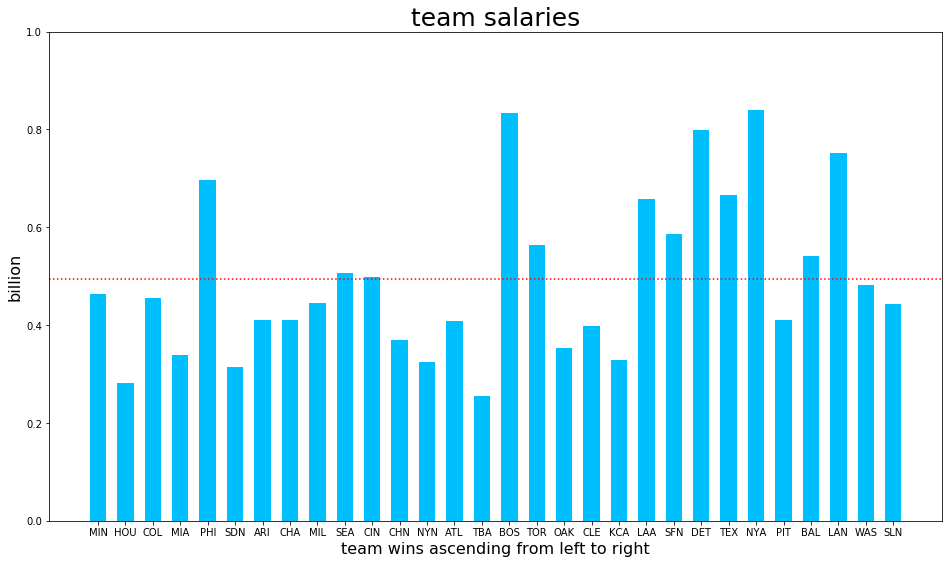

In [52]:
def draw_teams_salaries():
    #球队胜场从左到右升序，薪酬单位转换为billion
    draw_var = teams_unique_teamID.sort_values('W')['salary']/1000000000
    var_array = np.arange(len(draw_var))
    fig, ax = plt.subplots(figsize = (16,9)) 
    #设置子图属性
    ax.set_ylim([0,1])
    ax.set_xlabel('team wins ascending from left to right',fontsize =16)
    ax.set_ylabel('billion', fontsize = 16)
    ax.set_title('team salaries', fontsize = 25)  
    ax.bar(var_array, draw_var, width = 0.6, color = 'deepskyblue')
    #设置一条水平虚线，代表薪酬平均值
    plt.axhline(y = teams_unique_teamID['salary'].mean()/1000000000 , color = 'r', linestyle = 'dotted')
    plt.setp(ax, xticks=var_array, xticklabels = list(teams_unique_teamID.sort_values('W')['teamID']))
    plt.show()
    
draw_teams_salaries()

所谓的传统豪门，波士顿红袜队BOS、纽约洋基队NYA和洛杉矶道奇队LAN薪酬都很高，不过只有道奇队近5年的胜场数符合投入，而波士顿红袜队成绩并不如意。

成绩最好的圣路易斯红雀队SLN和华盛顿国民队WAS的薪酬投入都低于平均值，而投入很多的费城人队PHI的成绩也很差。

In [53]:
#以下为计算球队"产投比（每个胜场需要付出的薪酬）"
team_wins = teams_unique_teamID.sort_values('W',ascending = False)[['teamID','W','salary']].copy()
team_wins = team_wins.reset_index().drop('index', axis = 1)

team_wins['salary/win'] = team_wins['salary'] / team_wins['W']
team_wins.sort_values('salary/win')['teamID']

15    TBA
10    KCA
17    NYN
28    HOU
24    SDN
12    OAK
18    CHN
4     PIT
26    MIA
11    CLE
0     SLN
16    ATL
1     WAS
22    CHA
23    ARI
21    MIL
3     BAL
19    CIN
20    SEA
27    COL
29    MIN
8     SFN
13    TOR
6     TEX
9     LAA
2     LAN
7     DET
25    PHI
5     NYA
14    BOS
Name: teamID, dtype: object

可以看出产投比较小的基本是中下游球队

产投比最低的分别是坦帕湾光芒队TBA、堪萨斯皇家队KCA和纽约大都会队NYN

产投比最高的分别是波士顿红袜队BOS、纽约洋基队NYA和费城人队PHI

In [54]:
#球队薪酬和其他指标的相关性
teams_correlations_matrix = teams_unique_teamID.corr()

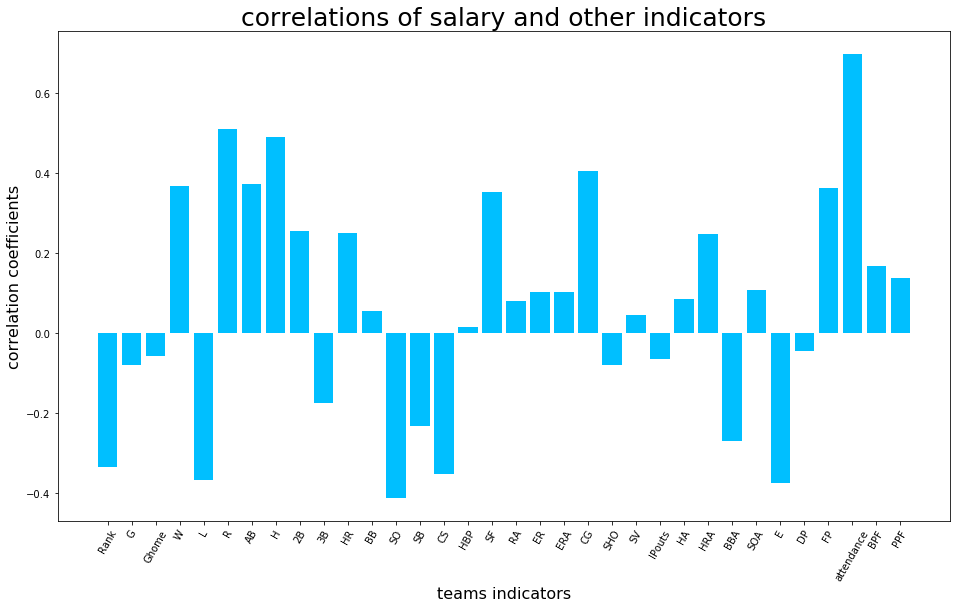

In [55]:
#画出和薪酬salary与其他指标的相关性直方图
def draw_team_bar():
    draw_var = teams_correlations_matrix['salary'].drop(['salary'])
    fig, ax = plt.subplots(figsize = (16,9)) 
    #设置子图属性
    ax.set_xlabel('teams indicators', fontsize = 16)
    ax.set_ylabel('correlation coefficients', fontsize = 16)
    ax.set_title('correlations of salary and other indicators', fontsize = 25)
    ax.bar(np.arange(len(draw_var)), draw_var, width = 0.8, color = 'deepskyblue')
    #利用setp设置ax对象的属性，修改x轴标签
    plt.setp(ax, xticks = np.arange(len(draw_var)), xticklabels = list(draw_var.index))
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation = 60)
    plt.show()
    
draw_team_bar()

观察发现和球队总薪酬相关性最高的居然是主场上座人数，相关性接近0.7，看来最吸引人气观众的豪门球会才有更多财力去给球员出高薪酬。

不过主场优势BPF和PPF的相关性并不高，估计观众多对球员也是一种压力啊。

薪酬和成绩Rank、W和L的相关性也符合常识，当然上面的分析里也看出大多数豪门其成绩只能排在第二梯队，成绩最好的5支球队里有3支的薪酬都低于平均值。

除此之外正相关前三的是回垒得分数R、击打数H和完投比赛次数CG，看来财大气粗的球队在攻击端的得分能力更强，而且能首发的主力投手也更多。

负相关较高的有被三振次数SO，失误次数E和盗垒失败次数CS，也证明了越高薪酬的球会攻击能力越丰富，失误越少。

## 总结

通过对数据的探索和观察，对最初提出的三个问题可推测：
* 对于击球手来说，强打能力越强，经验越丰富，其薪酬也会越高。对于投手来说，首发投手相比替补投手，其薪酬更高，经验越丰富，完封对手能力越强，薪酬会越高。
* 高薪酬击球手作为攻击核心虽然经常被对方投手保送，不过一旦有机会他们能更大概率地打出全垒打成为球队得分的主要来源。高薪酬投手主要是球队的首发投手，个人投球表现可能不怎么亮眼，但或许能通过和其他队友的配合为球队带来胜利。
* 球队付出更多薪酬确实能带来更好的成绩，但最好成绩的那几支球队未必是最高薪酬的球队。

以上之所以只是推测而非结论，是由于存在前提假设是否准确、数据集是否完整等等诸多因素所限制：
* 由于如果只分析某一年的数据球员会因为表现偏差很大而不能准确得出结论，因此在数据集里提取的是最近5年的数据，但并不清楚取平均薪酬作为分析前提是否准确，美职棒薪酬可能会受到外资进驻、通胀和汇率的影响，而美国14年退出QE后美元汇率确实也涨了不少（比如欧洲足球界薪酬、转会费这几年因为中东石油土豪进驻和英镑、欧元大跌而水涨船高）。
* 没有采用季后赛的数据，然而如果球队常常能打进季后赛，那么给球员高薪酬也是符合常识的。
* 在记录薪酬的数据集中并没有记录全部登场球员的薪酬，存在缺失，因此这里取用薪酬数据只是一个样本集，没取得总体数据在分析里不可避免会有一定误差，特别是在球队薪酬分析里，其他指标都是总体数据的情况下，误差可能会很大。
* 球会的“产投比”在投入里应该要包含球员转会费用投入，不过数据集并没有给出，同时产出好成绩的定义是胜场数，也没有考虑季后赛因素。
* 在排除不怎么击球的专职投手、捕手、野手抽取出击球手数据样本和排除救火队员抽取出投手数据样本时使用的方法可能比较粗糙，而且也可能会排除掉一些替补球员、长期养伤的球员等，这些都会影响样本的分析，虽然仍可以通过对比appearances的出场数据作为参考，不过暂时想不出比较好的分类筛选方法。
* 击球手的得分、安打、全垒打等累计型指标与其登场击打次数AB高度正相关，因此高薪酬击球手相比平均水平其表现指标的显著性可能需要进行检验。

## 参考

[棒球统计数据普及知识](http://blog.sina.com.cn/s/blog_6e1a6c670101bywu.html)

[棒球打击数据统计你能看懂多少？RBI SB TB..](http://blog.sina.com.cn/s/blog_6ab5684e0102v18t.html)

[matplotlib 柱状图、饼图；直方图、盒图](http://www.cnblogs.com/skyEva/p/5893693.html)

[【python数据挖掘课程】十五.Matplotlib调用imshow()函数绘制热图 - Eastmount的专栏 - CSDN博客](http://blog.csdn.net/Eastmount/article/details/73392106)

[python画bar图 - ASD991936157的博客 - CSDN博客](http://blog.csdn.net/asd991936157/article/details/54175197)
